In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init

In [2]:
train = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\train.csv')
train.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
795,1025,304.8,0.0,99.6,196.0,9.8,959.4,705.2,28,30.12
796,1026,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
797,1027,288.0,192.0,0.0,192.0,0.0,932.0,717.8,28,38.80
798,1028,450.1,50.0,0.0,200.0,3.0,1124.4,613.2,28,39.38
799,1029,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30


In [3]:
train1, test1 = train_test_split(train, test_size=0.3, random_state=42)

In [4]:
train1 = train1.reset_index(drop=True)
test1 = test1.reset_index(drop=True)

In [5]:
train1.isna().sum()

Id                    0
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [6]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  560 non-null    int64  
 1   Cement              560 non-null    float64
 2   Blast Furnace Slag  560 non-null    float64
 3   Fly Ash             560 non-null    float64
 4   Water               560 non-null    float64
 5   Superplasticizer    560 non-null    float64
 6   Coarse Aggregate    560 non-null    float64
 7   Fine Aggregate      560 non-null    float64
 8   Age                 560 non-null    int64  
 9   Strength            560 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 43.9 KB


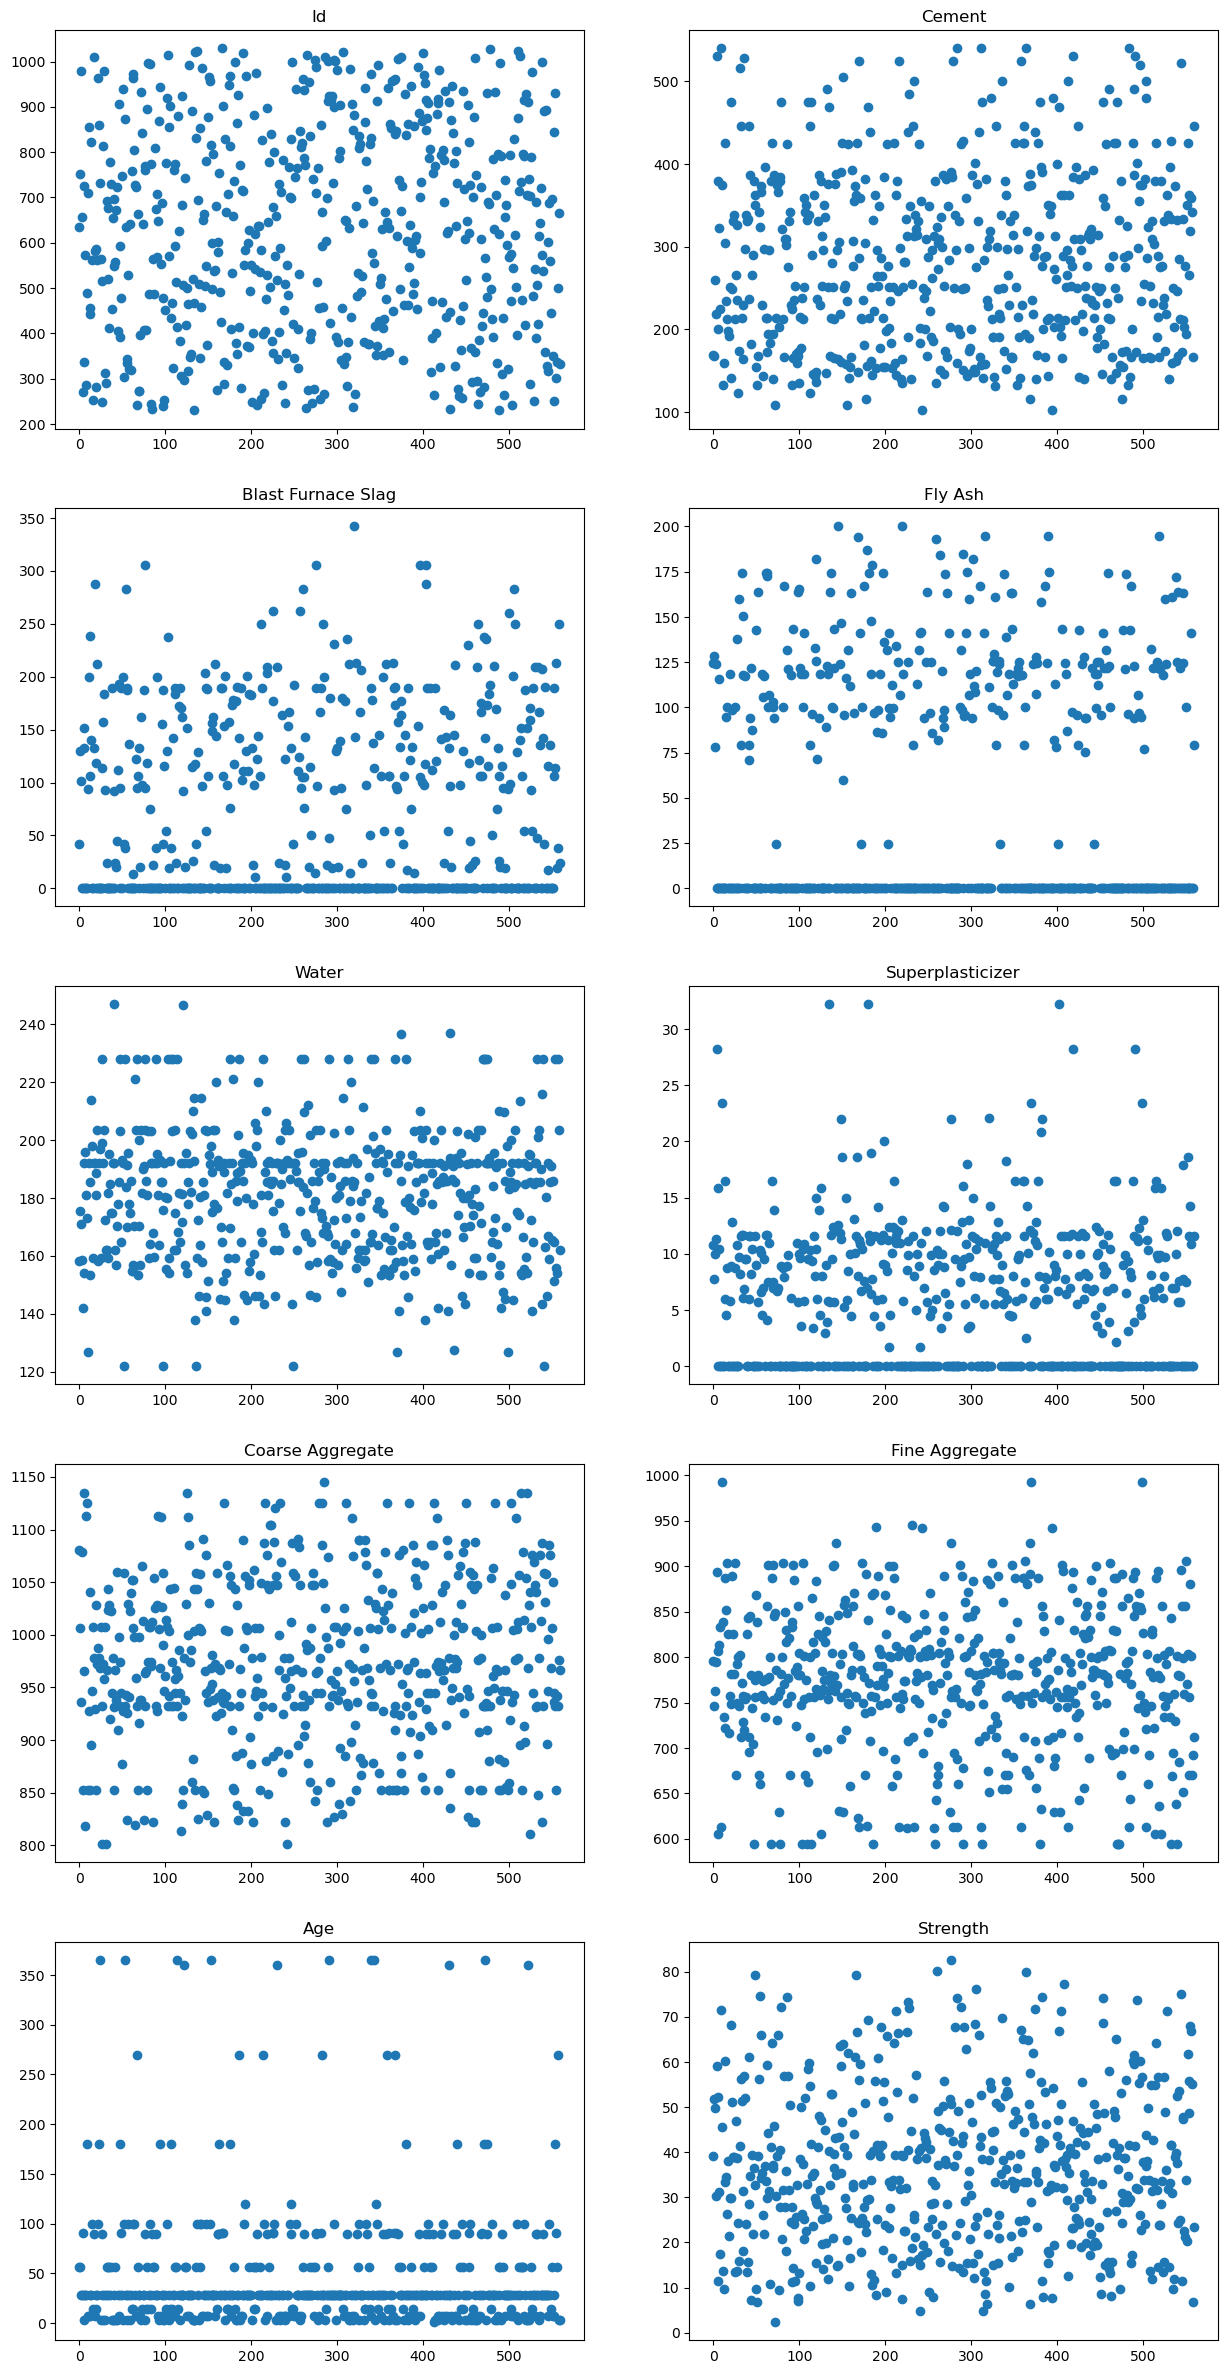

In [8]:
fig, axs = plt.subplots(figsize=(15, 30), nrows=5, ncols=2)
for ax, col in zip(axs.flat, train1.columns):
    ax.scatter(train1.index, train1[col])
    ax.set_title(col)

In [146]:
def quantilecount(dframe, cols: list):

    dframe2 = dframe.copy()

    for col in dframe.drop(columns=cols):

        qMin = dframe[col].quantile(0.25)
        qMax = dframe[col].quantile(0.75)
        iqr = qMax - qMin
        bounds = (qMin - iqr*1.5, iqr*1.5 + qMax)

        dframe2 = dframe2[dframe2[col] >= bounds[0]].copy()
        dframe2 = dframe2[dframe2[col] <= bounds[1]].copy()

    return dframe2.reset_index(drop=True)

In [89]:
def new(dframe):
    df = dframe.copy()
    df['Cement/Water'] = df['Cement'] / df['Water']
    df['Water/Age'] = df['Water'] / df['Age']
    df['Superplasticizer/Age'] = df['Superplasticizer'] / df['Age']
    df['Coarse/Fine'] = df['Coarse Aggregate'] / df['Fine Aggregate']

    df['pC'] = df['Cement'].apply(lambda x: 1 if x >= df['Cement'].describe()[1] else 0)
    df['pSp'] = df['Superplasticizer'].apply(lambda x: 1 if x >= df['Superplasticizer'].describe()[1] else 0)
    df['pW'] = df['Water'].apply(lambda x: 1 if x >= df['Water'].describe()[1] else 0)
    df['10a'] = df['Age'].apply(lambda x: x/10)
    df['pA'] = df['Age'].apply(lambda x: 1 if x >= df['Age'].describe()[1] else 0)

    try:
        if df['Strength'] is not None:
            cols=['Id', 'Strength', 'pC', 'pSp', 'pW', 'pA']

    except KeyError:
        cols=['Id', 'pC', 'pSp', 'pW', 'pA']



    df_scaler = StandardScaler().fit_transform(df.drop(columns=cols))
    df2 = pd.concat([df[cols],
                       pd.DataFrame(data=df_scaler, columns=df.drop(columns=cols).columns)], axis=1).reset_index(drop=True)
    
    return df2


In [148]:
def inf_emp_val(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe.isnull()[col].sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe[col].isin([np.inf, -np.inf]).sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [10]:
train2 = new(train1)
test2 = new(test1)

In [11]:
xtrain = train2.drop(columns=['Id', 'Strength'])
ytrain = train2.Strength

xtest = test2.drop(columns=['Id', 'Strength'])
ytest = test2.Strength

# DecisionTreeRegressor----------------------------------------------------------------------

In [13]:
dtr = DecisionTreeRegressor(random_state=42).fit(xtrain, ytrain)
predDTR = dtr.predict(xtest)
root_mean_squared_error(ytest, predDTR)

7.688238379173736

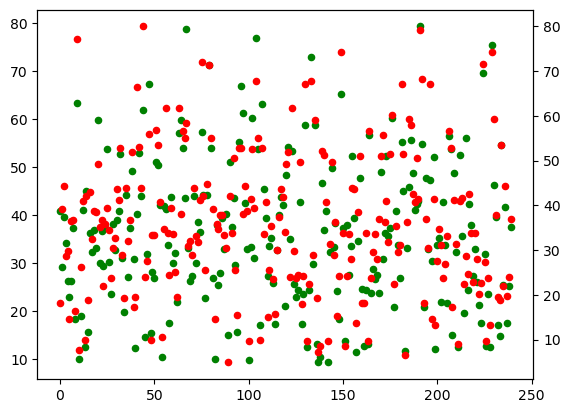

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predDTR, c='r', s=20);

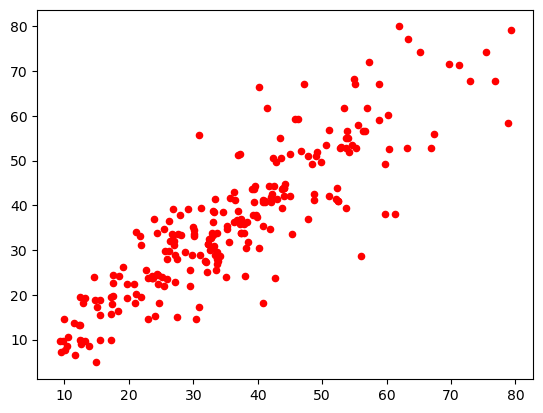

In [15]:
plt.scatter(ytest, predDTR, c='r', s=20);

# NN------------------------------------------------------------------------------------------------------

In [97]:
class Set(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy().astype('float32'))
        self.y = torch.tensor(y.to_numpy().astype('float32'))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.x.shape[0]

In [98]:
traindata = Set(xtrain, ytrain)
trainloader = DataLoader(dataset=traindata, batch_size=80, shuffle=True)

In [99]:
for batch, [x, y] in enumerate(trainloader, 1):
    print(batch, x.shape, y.shape)

1 torch.Size([80, 17]) torch.Size([80])
2 torch.Size([80, 17]) torch.Size([80])
3 torch.Size([80, 17]) torch.Size([80])
4 torch.Size([80, 17]) torch.Size([80])
5 torch.Size([80, 17]) torch.Size([80])
6 torch.Size([80, 17]) torch.Size([80])
7 torch.Size([80, 17]) torch.Size([80])


In [108]:
class Net(nn.Module):
    def __init__(self, one, two, three, four, five, six, seven):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
                                    # 80 x 15
        nn.Linear(one, two), # 80
        nn.ReLU(),
        nn.Linear(two, three), # 80
        nn.ReLU(),
        nn.Linear(three, four), # 5120
        nn.ReLU(),
        nn.Linear(four, five), # 640
        nn.ReLU(),
        nn.Linear(five, six), # 4
        nn.ReLU(),
        nn.Linear(six, seven), # 1
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.seq(x)
        return x

In [100]:
class Net(nn.Module):
    def __init__(self, one, two, three, four, five, six):
        super().__init__()
        self.mat1 = nn.Linear(one, two)
        self.mat2 = nn.Linear(two, three)
        self.mat3 = nn.Linear(three, four)
        self.mat4 = nn.Linear(four, five)
        self.mat5 = nn.Linear(five, six)
        self.func1 = nn.ReLU()
        self.func2 = nn.LeakyReLU(negative_slope=0.001)
        self.func3 = nn.Tanh() 
        
        init.xavier_uniform_(self.mat1.weight)
        init.xavier_uniform_(self.mat2.weight)
        init.xavier_uniform_(self.mat3.weight)
        init.xavier_uniform_(self.mat4.weight)
        init.xavier_uniform_(self.mat5.weight)
        
        
    def forward(self, x):
        x = self.func3(self.mat1(x))
        x = self.func1(self.mat2(x))
        x = self.func1(self.mat3(x))
        x = self.func2(self.mat4(x))
        x = self.mat5(x)
        return x
    
    def preprint(self):
        print(self.mat5.weight)
    
# init.xavier_uniform_(Line.weight)
# init.zeros_(Line.bias)
    
    
model = Net(xtrain.shape[1], 1280, 1280, 80, 80, 1)
print(model)
print(model.preprint())

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

Net(
  (mat1): Linear(in_features=17, out_features=1280, bias=True)
  (mat2): Linear(in_features=1280, out_features=1280, bias=True)
  (mat3): Linear(in_features=1280, out_features=80, bias=True)
  (mat4): Linear(in_features=80, out_features=80, bias=True)
  (mat5): Linear(in_features=80, out_features=1, bias=True)
  (func1): ReLU()
  (func2): LeakyReLU(negative_slope=0.001)
  (func3): Tanh()
)
Parameter containing:
tensor([[ 0.1951,  0.1121,  0.1015,  0.0584, -0.0485,  0.1663, -0.1755, -0.1023,
          0.0026, -0.0403,  0.2373,  0.2017,  0.2645,  0.1432, -0.1475, -0.1341,
         -0.0748, -0.1584, -0.0296, -0.2436, -0.2095,  0.0439,  0.1733, -0.0635,
          0.2179, -0.1541, -0.0947,  0.0169,  0.1002, -0.2345, -0.2427, -0.2359,
          0.0744, -0.1505,  0.0765, -0.1503, -0.0169, -0.2239, -0.0768, -0.1433,
          0.1893, -0.0726, -0.1712, -0.2093,  0.1181, -0.0127, -0.1085,  0.1736,
          0.0921, -0.0972, -0.1567,  0.2525, -0.2518,  0.2292,  0.0307, -0.0258,
         -0.0

In [20]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [101]:
losslist1 = []
losslist2 = []

for batch in range(6000):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []

Mean:  3.7174527828211765 

Median:  0.6047548034361431 

Min:  0.30016043675797327 



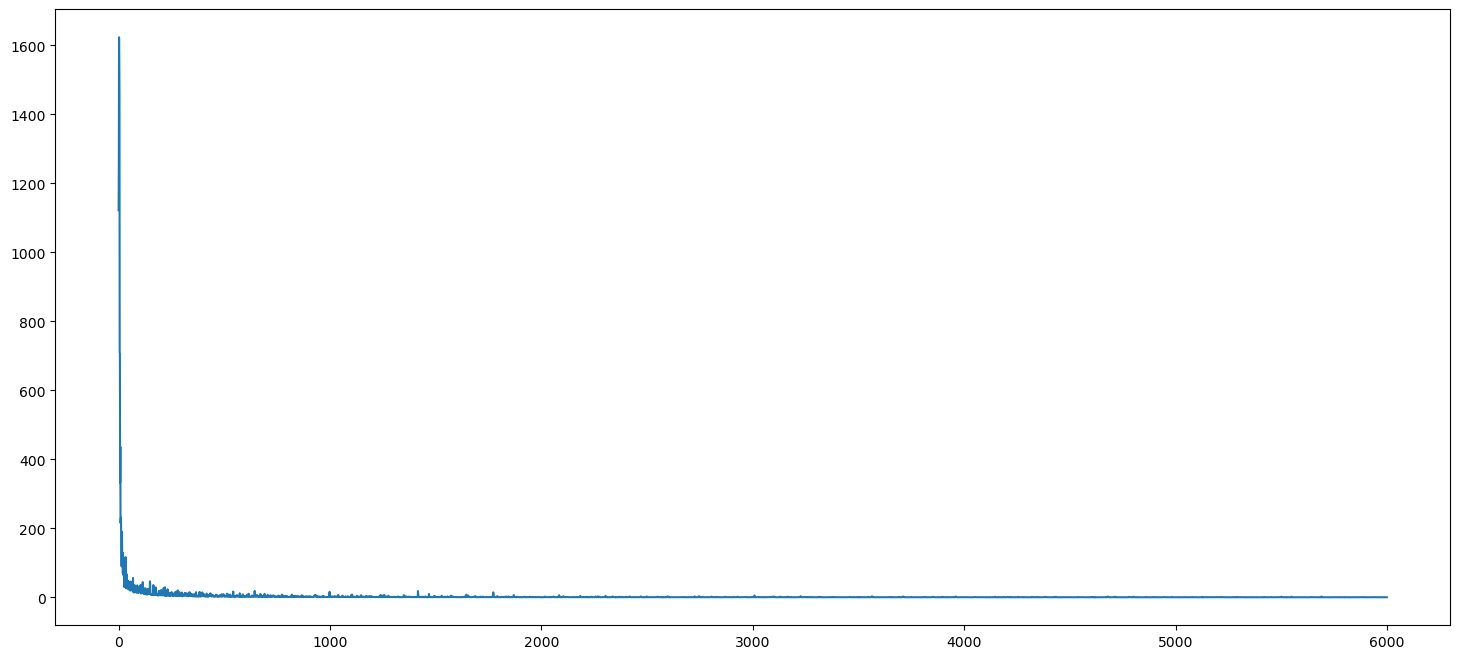

In [102]:
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [103]:
with torch.no_grad():
    predNN = model(torch.tensor(xtest.to_numpy().astype('float32')))

print('RMSE: ', root_mean_squared_error(ytest, predNN), '\n')
print('MSE: ', mean_squared_error(ytest, predNN))

RMSE:  4.964680139737863 

MSE:  24.648048889907564


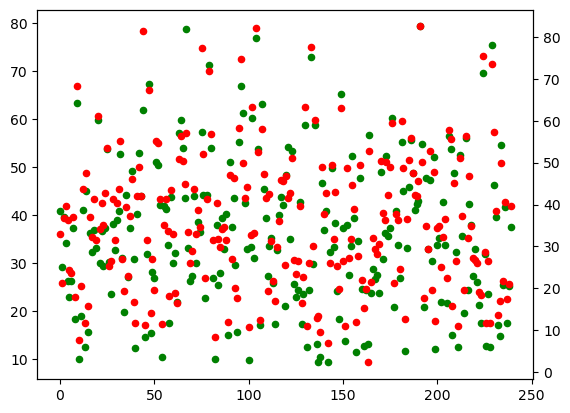

In [104]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predNN, c='r', s=20);

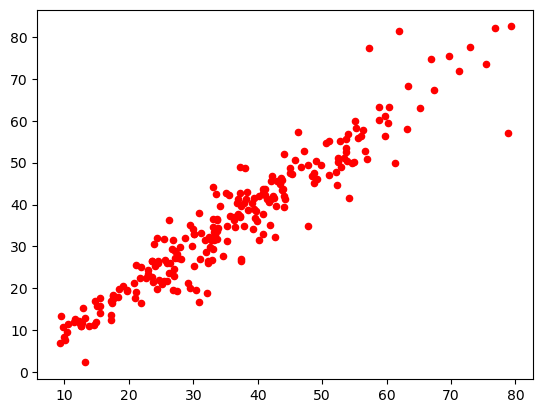

In [105]:
plt.scatter(ytest, predNN, c='r', s=20);

# Final test modeling-----------------------------------------------------------------------------------

In [106]:
TRAIN = new(train)

X = TRAIN.drop(columns=['Id', 'Strength'])
Y = TRAIN['Strength']

Mean:  3.315809241362025 

Median:  0.8100187826901675 

Min:  0.42843382954597475 



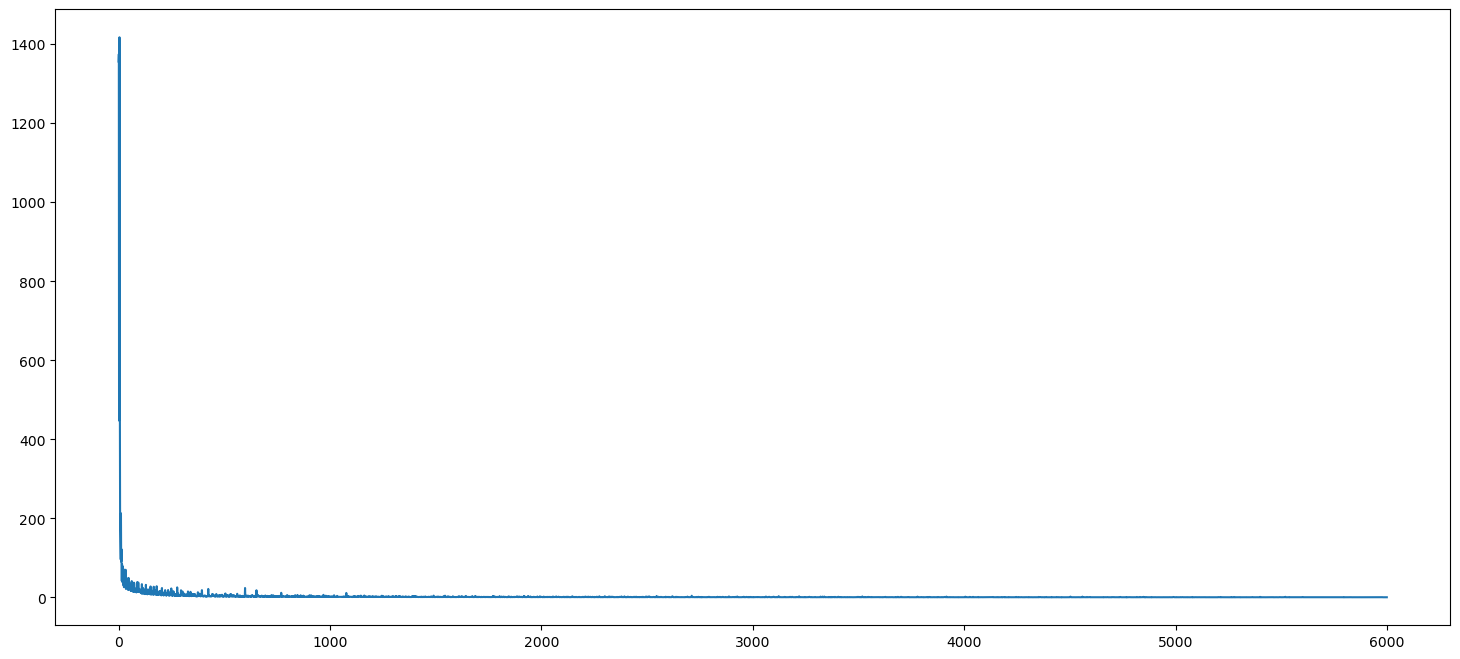

In [107]:
model = Net(X.shape[1], 1280, 1280, 80, 80, 1)

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

traindata = Set(X, Y)
trainloader = DataLoader(dataset=traindata, batch_size=80, shuffle=True)

losslist1 = []
losslist2 = []

for batch in range(6000):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []
    
    
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [108]:
test = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\test.csv')

TEST = new(test)
TEST1 = TEST.drop(columns=['Id'])

In [109]:
with torch.no_grad():
    predNNtest = model(torch.tensor(TEST1.to_numpy().astype('float32')))

In [110]:
predicted_Strength = pd.DataFrame(data={'Id': TEST['Id'], 'Strength': predNNtest.squeeze()})
predicted_Strength.to_csv('Rver25.csv', index=False)

# Tests

In [ ]:
model1 = Net(8, 512, 1024, 512, 2, 1)

In [77]:
for param in model1.parameters():
    print(param.shape)

NameError: name 'model1' is not defined

In [15]:
import torch.nn.init as init

Line = nn.Linear(3, 3, bias=True)

sample = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=torch.float32)
Line(sample)


init.xavier_uniform_(Line.weight)
init.constant_(Line.weight, 1)

init.zeros_(Line.bias)
init.constant_(Line.bias, 1)

print('weight: ', Line.weight)
print('bias: ', Line.bias)

weight:  Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
bias:  Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
